# Difference analysis imputed and hard NaN trainingsets 

## Import libararies

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

## Import datasets

In [2]:
data_train_noimpute = pd.read_csv('../datasets/ml_bwi_v3_train_noimpute.csv')
data_train_imputed = pd.read_csv('../datasets/ml_bwi_v3_train_imputed.csv')
data_test = pd.read_csv('../datasets/ml_bwi_v3_test.csv')

# remove index column in data_train_imputed 
data_train_imputed.drop(columns='Unnamed: 0', inplace=True)

In [3]:
data_train_noimpute

,Tnr,Enr,bl,Ba,Al_ba,Bs,Bhd,Hoehe,D7,D03,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,11,2,9,Spruce,119.0,main stand,330,132.0,242.0,274.0,...,15.01,-1.07,2041,278,105,0.30,727,382,727,382
1,11,2,9,Spruce,139.0,main stand,540,176.0,365.0,450.0,...,15.01,-1.07,2041,278,105,0.30,727,382,727,382
2,11,2,9,Spruce,149.0,main stand,520,261.0,398.0,403.0,...,15.01,-1.07,2041,278,105,0.30,727,382,727,382
3,11,2,9,Spruce,149.0,main stand,528,217.0,385.0,389.0,...,15.01,-1.07,2041,278,105,0.30,727,382,727,382
4,18,1,9,Spruce,150.0,main stand,750,355.0,578.0,606.0,...,11.99,-3.12,2920,383,162,0.27,1007,577,1007,577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67139,57557,4,14,Larch,50.0,main stand,246,248.0,206.0,199.0,...,14.24,-1.98,865,120,48,0.27,292,174,292,191
67140,57557,4,14,Larch,50.0,main stand,310,260.0,255.0,245.0,...,14.24,-1.98,865,120,48,0.27,292,174,292,191
67141,57557,4,14,Spruce,50.0,main stand,220,214.0,175.0,195.0,...,14.24,-1.98,865,120,48,0.27,292,174,292,191
67142,57557,4,14,Spruce,50.0,main stand,263,246.0,213.0,226.0,...,14.24,-1.98,865,120,48,0.27,292,174,292,191


## Summary splitting and imputation process

1. StratifiedGroupKFold split with 5 folds (to achieve 80/20 partition) -> break after first 
2. Remove all NaNs in the testset since we do not impute on the testset to prevent a change in distribution here 
3. 'Copy' the trainset and remove all NaNs -> trainset with hard NaN removal 
4. 'Copy' the trainset and perform KNNImputation for all missing values 

Step 4: 
- Scaling all numerical values 
- (Again) indexing the categorical values
- using a kNN-Imputer with k=1 to receive imputed integer values 
- Replacing indexes with categorical values 

=> **Using the imputed trainset we only need to onehot-encode, numerical values are already scaled with zero mean and unit variance**

## Number of instances

In [3]:
print(data_train_noimpute.shape)
print(data_train_imputed.shape)
print(data_test.shape)


(67144, 51)
(137885, 51)
(16764, 51)


The following table shows the number of instances per dataset.

We can see that by using **imputation**, we create a dataset which is around **twice as large as the training set coming from a hard NaN removal from the generated dataset**. 

|dataset|features|instances|
|-------|--------|---------|
|test (nan removed)|47|16764|
|train hard nan removal|47|67144|
|train imputed|47|137885|



## Tree species distribution in the 3 sets

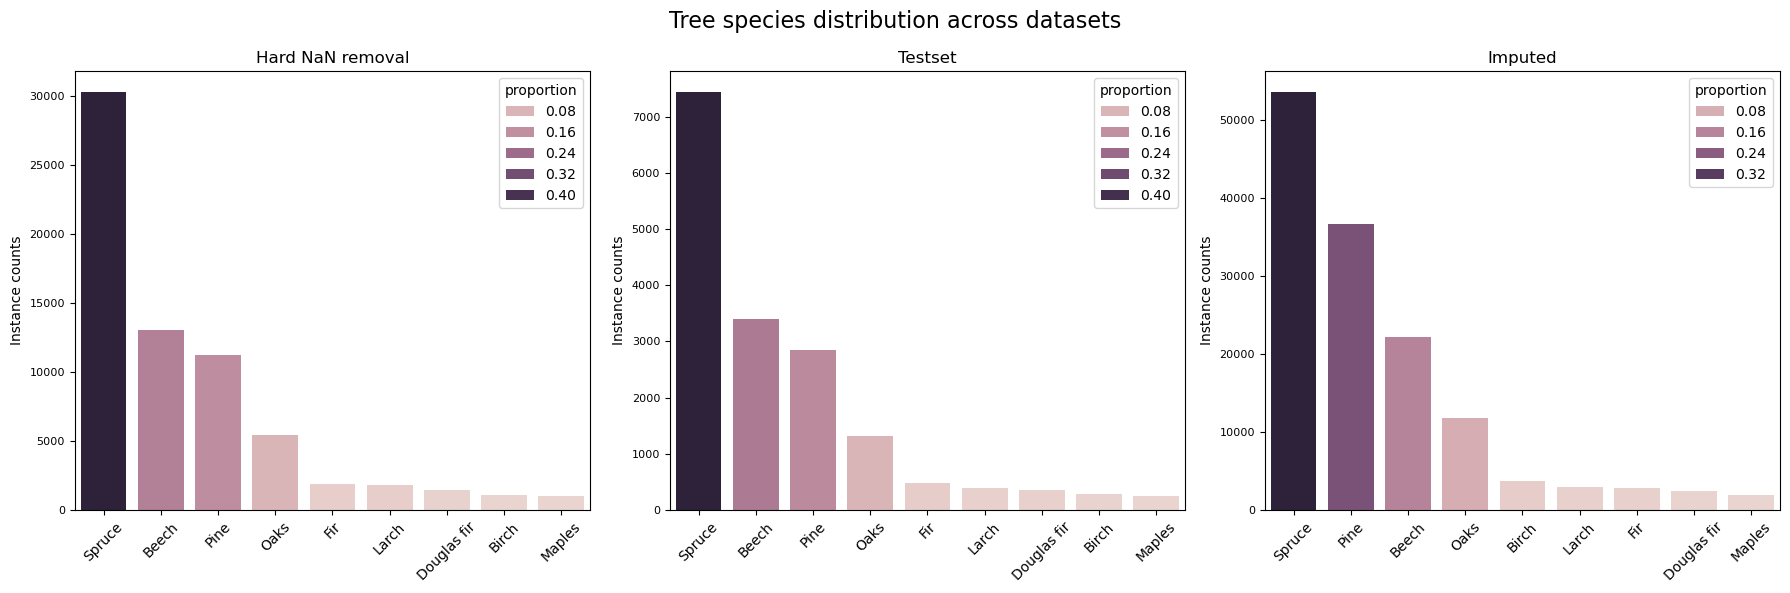

In [4]:
# Plot species distribution
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot for data_train_noimpute
sns.barplot(x=data_train_noimpute['Ba'].value_counts().index, 
            y=data_train_noimpute['Ba'].value_counts().values, 
            hue=data_train_noimpute['Ba'].value_counts(normalize=True),
            ax=axs[0])
axs[0].set_title('Hard NaN removal')

# Plot for data_test
sns.barplot(x=data_test['Ba'].value_counts().index, 
            y=data_test['Ba'].value_counts().values, 
            hue=data_test['Ba'].value_counts(normalize=True),
            ax=axs[1])
axs[1].set_title('Testset')

# Plot for data_train_imputed
sns.barplot(x=data_train_imputed['Ba'].value_counts().index, 
            y=data_train_imputed['Ba'].value_counts().values, 
            hue=data_train_imputed['Ba'].value_counts(normalize=True),
            ax=axs[2])
axs[2].set_title('Imputed')

for ax in axs:
    ax.set_xlabel('')
    ax.set_ylabel('Instance counts')
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', labelsize=8)

fig.suptitle('Tree species distribution across datasets', fontsize=16)
fig.tight_layout()
plt.show()

**Observation**: **(Trainsets)** Imputation does not only increase the number of samples, it changes the order of species quantities. While spruces are still the most represented in the dataset its proportion is reduced due to an increased number of pines and beech. We include around 25k pine instances such that it becomes the second most represented species in the dataset, follwed by beeches third. Also we can add instances to the lesser represented species (from which birches seem to profit the most), we are not able to balance the dataset with imputation.

**(Testset)** As expected the hard-nan-removal-trainset shares the same species distribution in terms of relative quantities and ordering. With descriptions above we see that this does not hold for the imputed-trainset.

**Conclusion**: When training with both trainsets we have to weight the species respectively! 

## Comparison numerical features

In [18]:
features_noimpute = data_train_noimpute.drop(['Ba', 'Tnr', 'Enr', 'bl'], axis=1)
features_imputed = data_train_imputed.drop(['Ba', 'Tnr', 'Enr', 'bl'], axis=1)

num_features = features_noimpute.select_dtypes(include=[np.number]).columns.to_list()

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_noimpute_toplot = scaler.fit_transform(features_noimpute[num_features])
features_noimpute_toplot = pd.DataFrame(features_noimpute_toplot, columns=num_features)

In [21]:
features_imputed_toplot = features_imputed[num_features]

In [22]:
features_noimpute_toplot['dataset'] = 'No Impute'
features_imputed_toplot['dataset'] = 'Imputed'
combined_data = pd.concat([features_noimpute_toplot, features_imputed_toplot], ignore_index=True)
melted_data = combined_data.melt(id_vars='dataset', var_name='feature', value_name='value')

C:\Users\davha\AppData\Local\Temp\ipykernel_25052\3286207046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_imputed_toplot['dataset'] = 'Imputed'


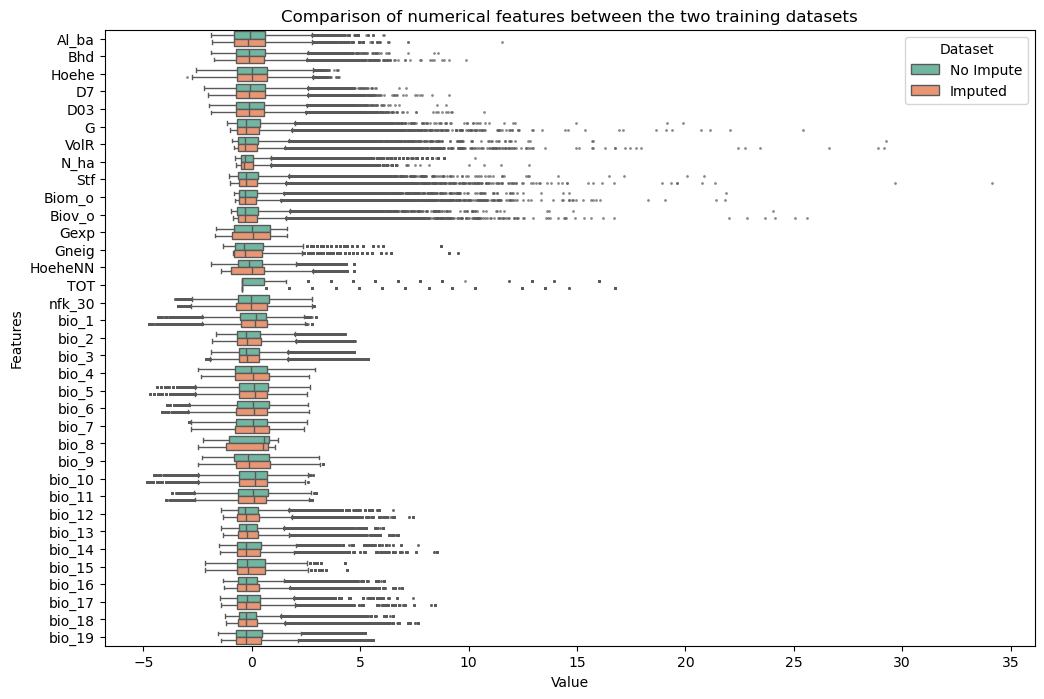

In [26]:
# Create the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=melted_data,
            x='value',
            y='feature',
            hue='dataset',
            orient='h',
            palette='Set2',
            flierprops=dict(marker='o', markersize=1, alpha=0.7))
plt.title('Comparison of numerical features between the two training datasets')
plt.xlabel('Value')
plt.ylabel('Features')
plt.legend(title='Dataset')
plt.show()

**Observation**: Imputation does not seem to change the distribution of the numerical values significantly. We can observe that outliers may vary more between the two datasets. The TOT feature - giving the number of deadwood pieces in the sample plot, the tree is situated - has an average and quantiles (0.25, 0.75) of zero, which is explainable by adding more zeros when imputing. 

**Conclusion**: For the numerical columns we expect both datasets to capture comparable variance of the dataset. 

## Comparison categorical features

In [29]:
cat_features = features_noimpute.select_dtypes(include=['object']).columns.to_list()

In [30]:
combined_df = pd.concat([
    features_noimpute[cat_features].assign(dataset='No Impute'),
    features_imputed[cat_features].assign(dataset='Imputed')
])

In [34]:
def groupby_feature_count_cols(df, feature):
    df = df.groupby(['dataset', feature]).size().reset_index(name='count')
    df['normalized_count'] = df.groupby('dataset')['count'].transform(lambda x: x / x.sum())
    df['normalized_count'] = df['normalized_count'].round(2)
    return df

In [40]:
def custom_cat_plot(df, feature):
    g = sns.FacetGrid(df, col='dataset', col_wrap=2, height=4, aspect=1.5)
    g.map_dataframe(sns.barplot, x=feature, y='count', hue='normalized_count', palette='dark:#1f77b4')
    g.add_legend(title='Normalized Count')
    for ax in g.axes.flat:
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    plt.show()


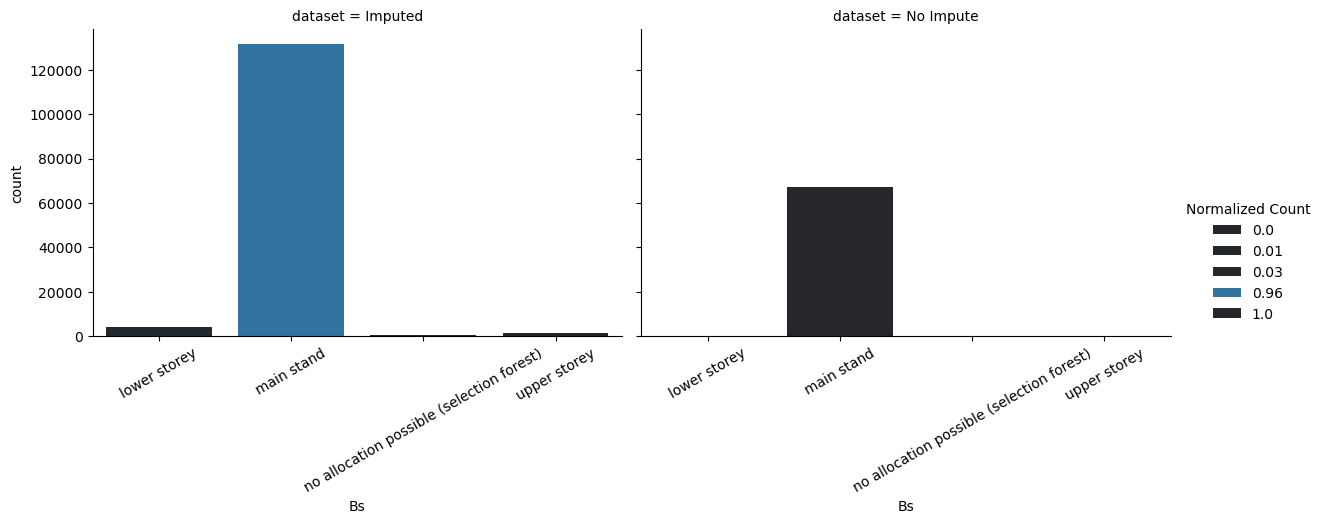

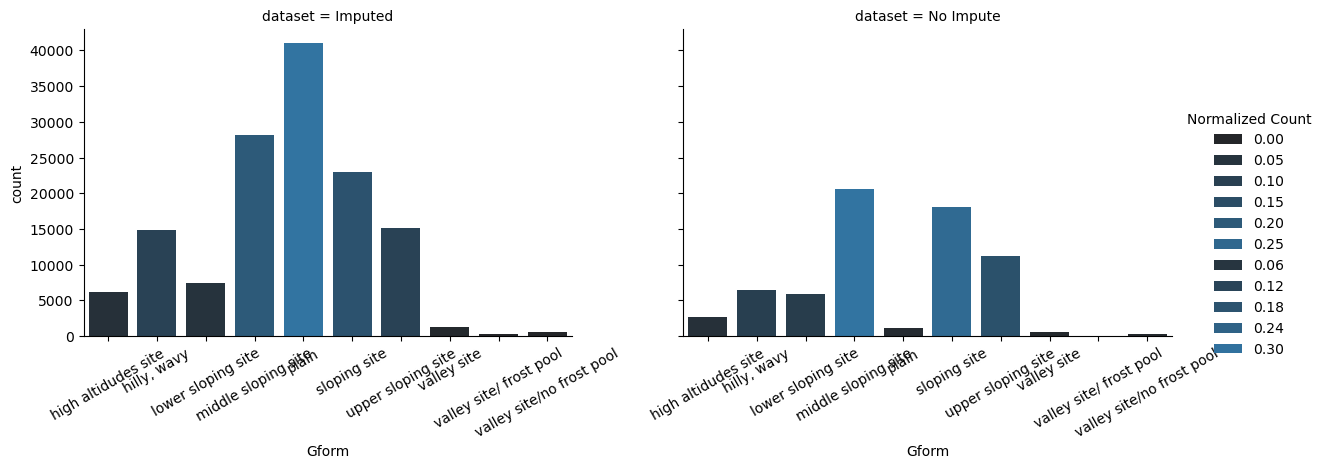

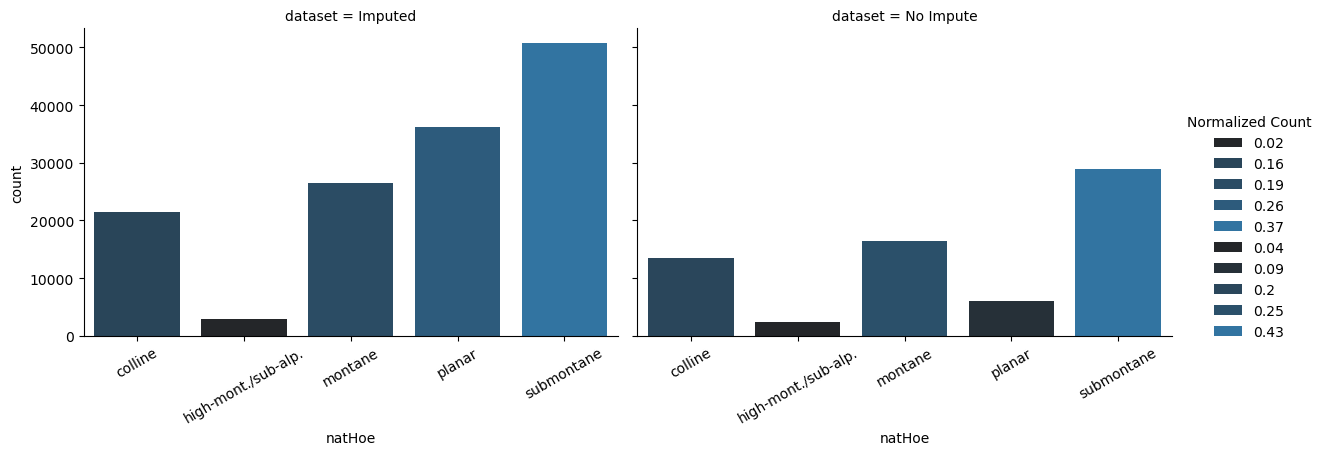

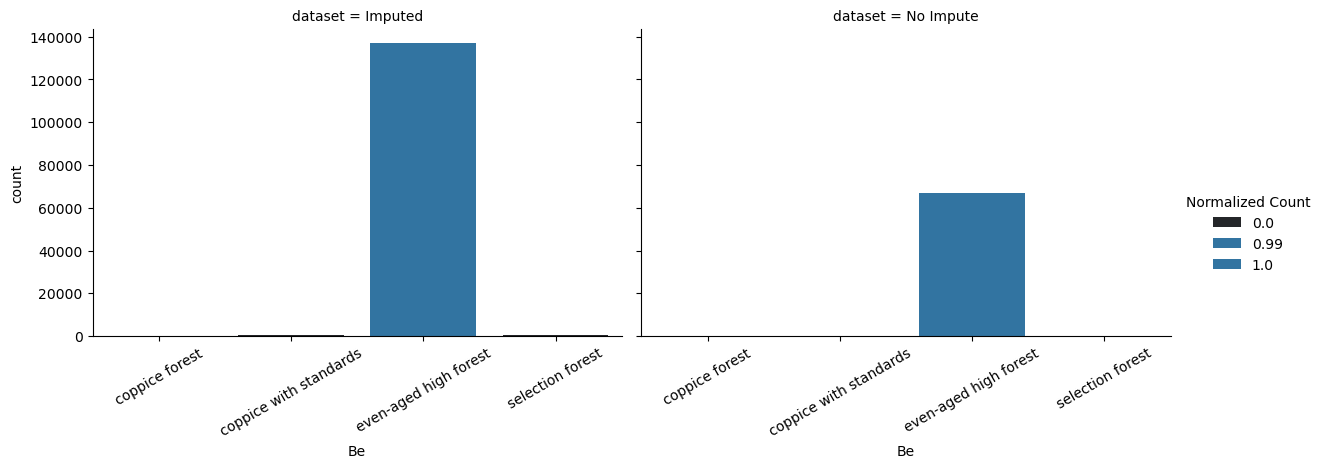

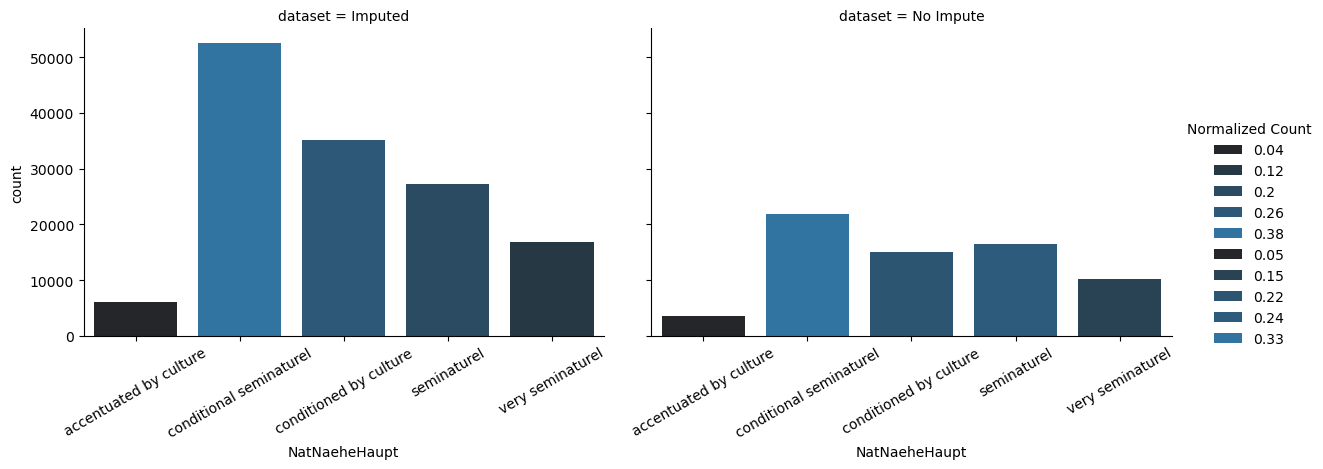

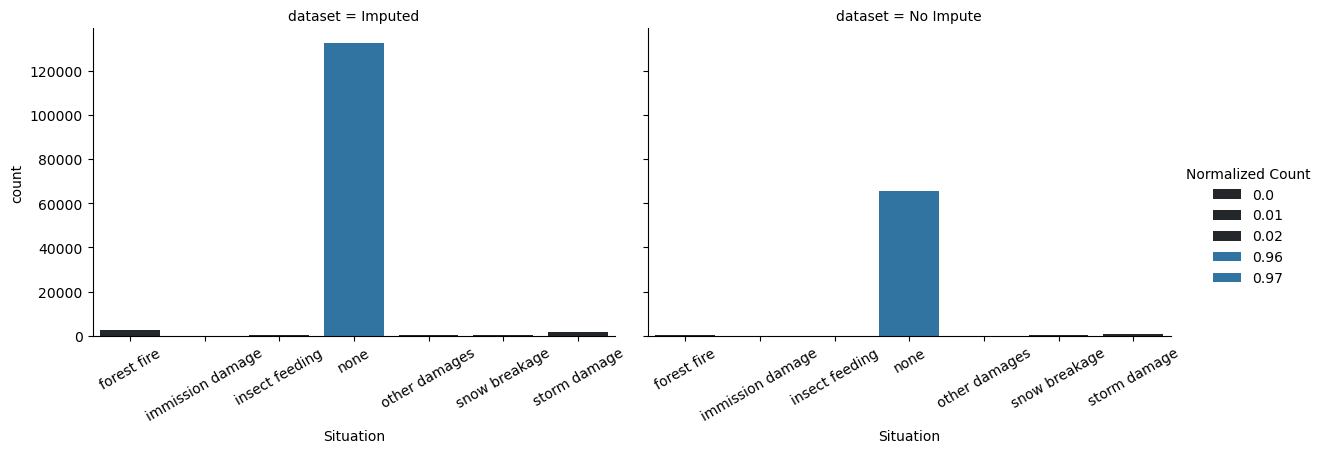

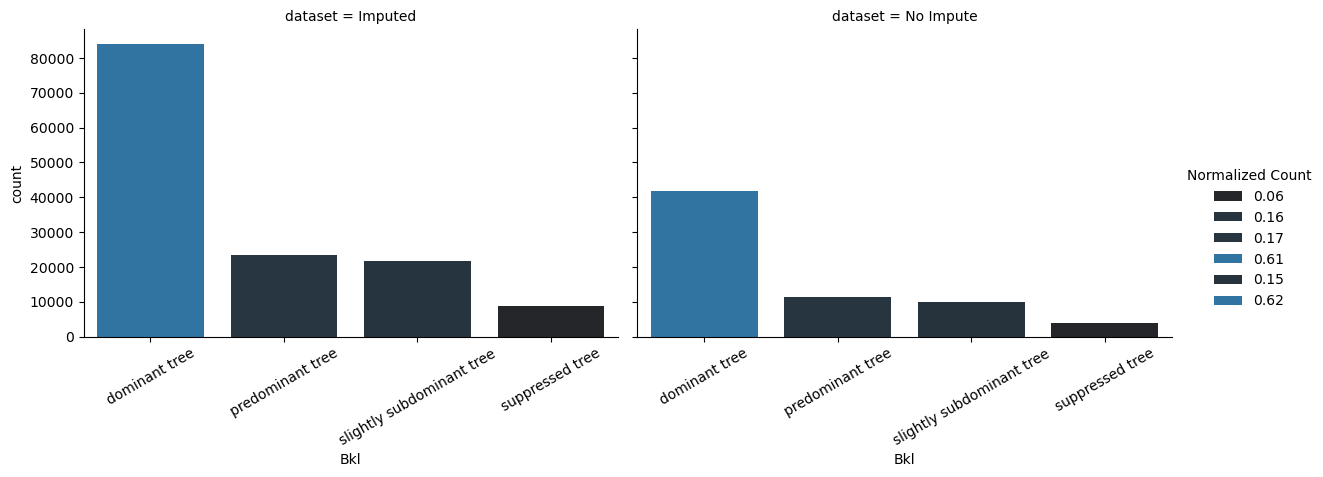

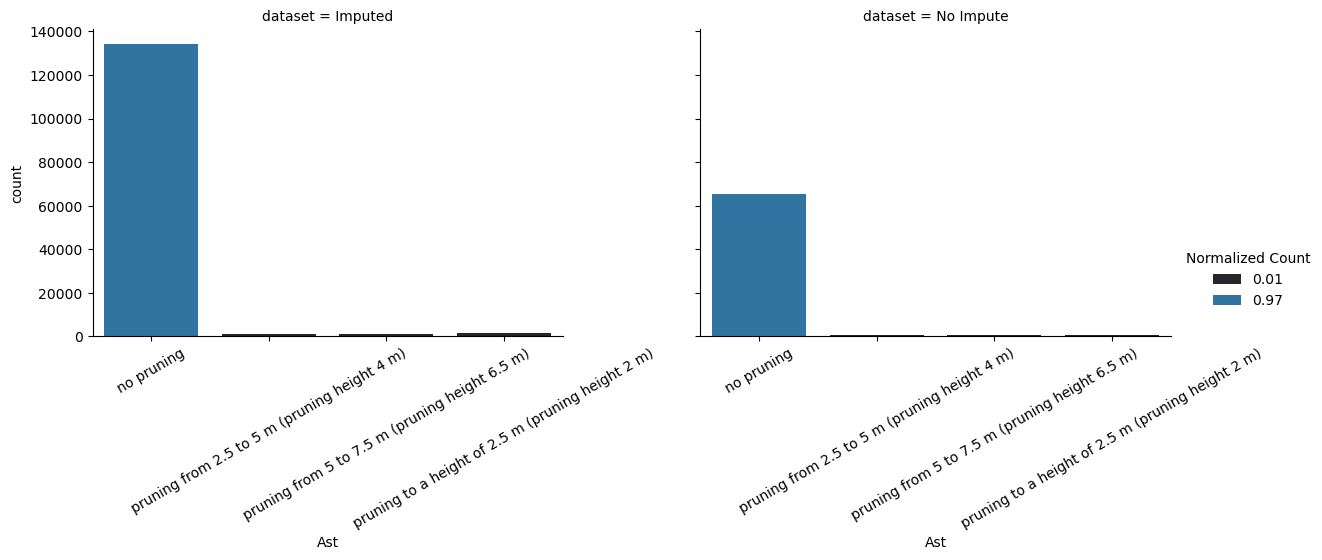

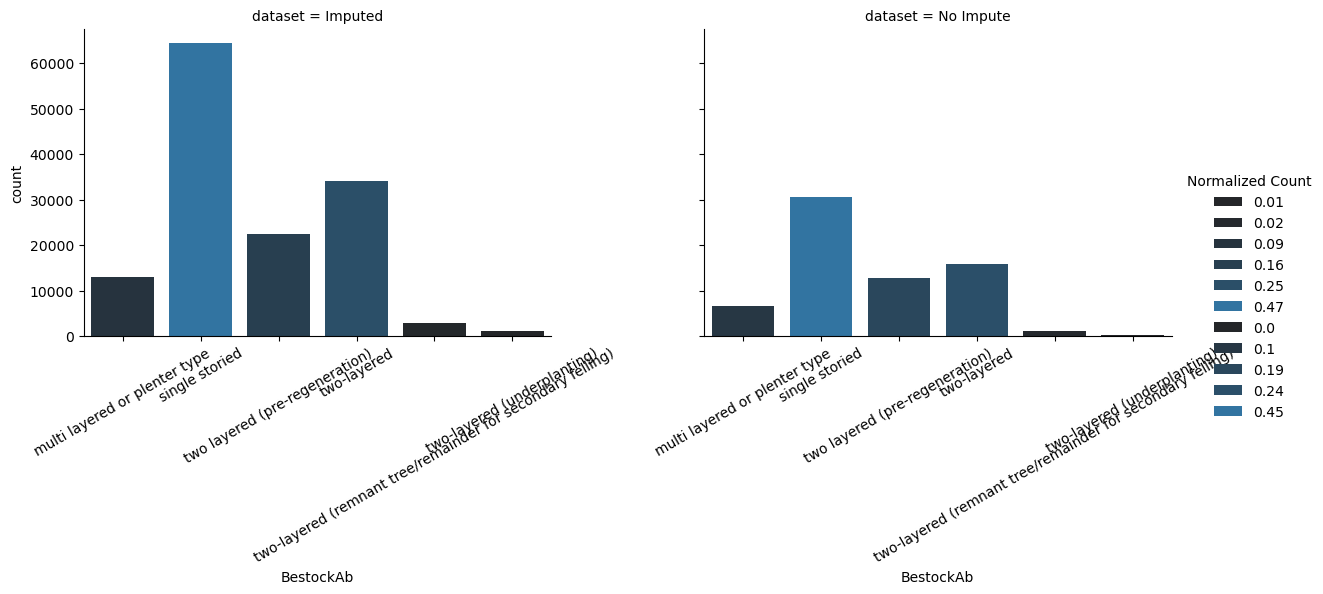

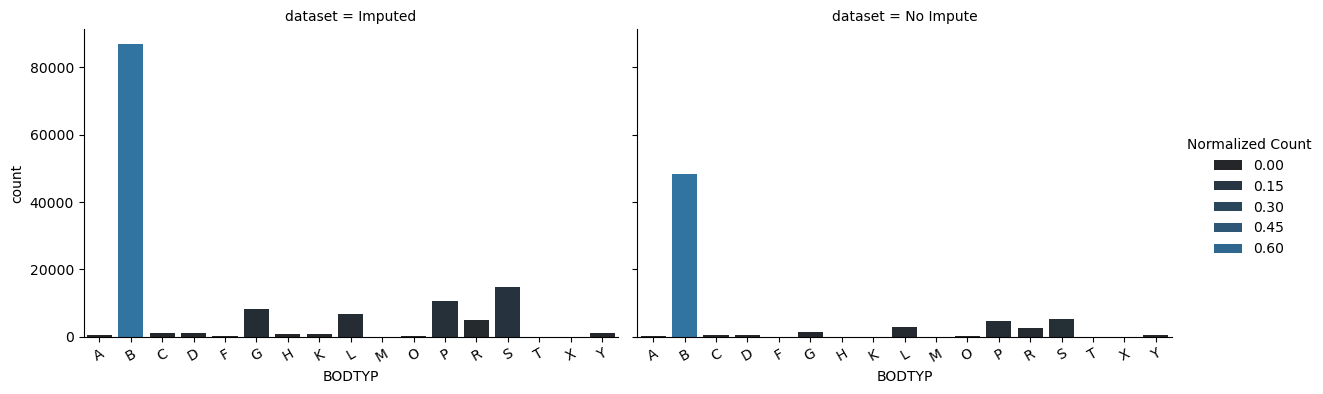

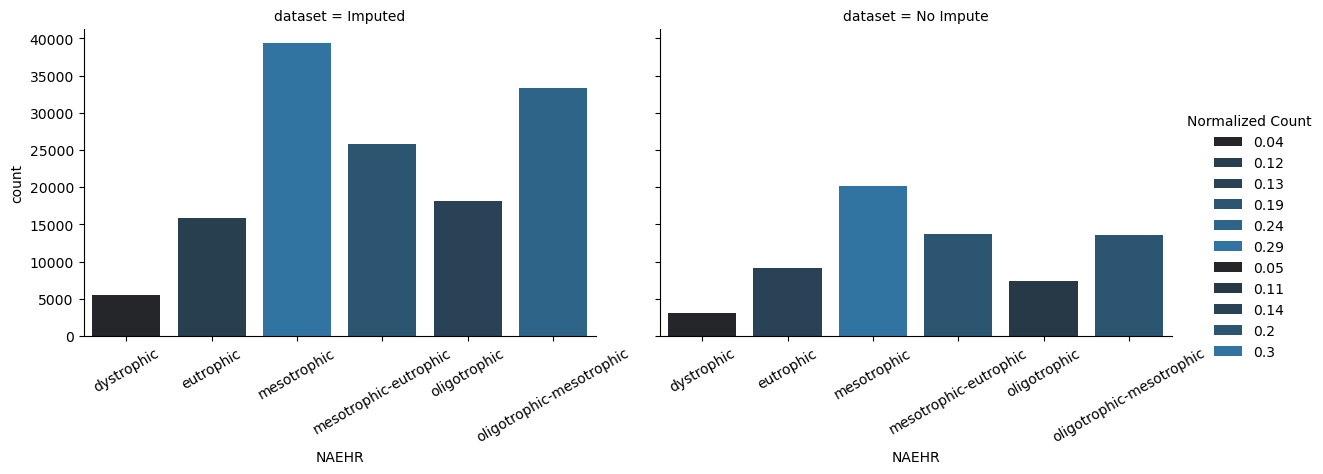

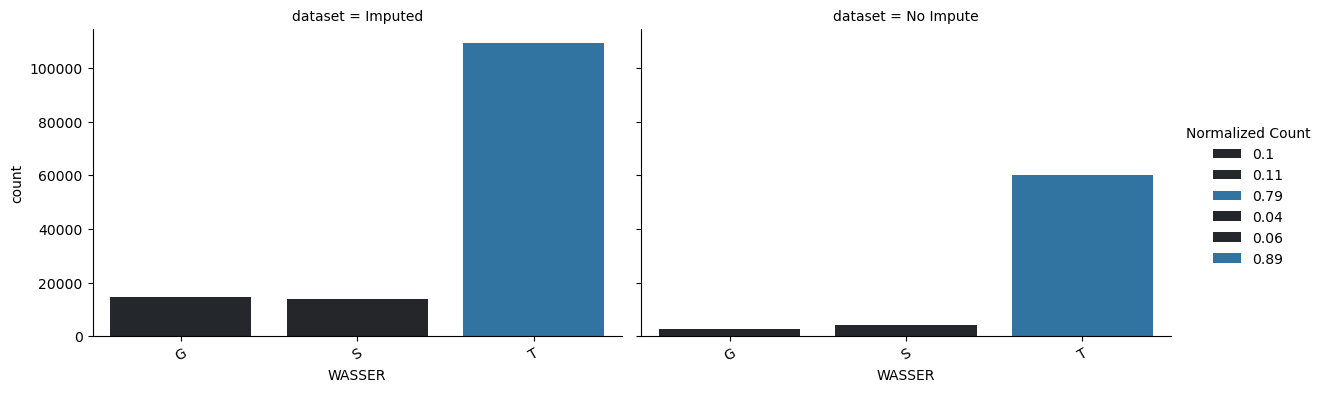

In [41]:
%matplotlib inline

for i, feature in enumerate(cat_features):
    df = groupby_feature_count_cols(combined_df, feature)
    custom_cat_plot(df, feature)


**Observation**: In general imputation seems to lead to more variability in the categorical columns. We can observe that the quantity of less represented categories is increased which in can lead to changes in the order of quantities for certain quantities like natNaeheHaupt. (Most NaNs in Brandenburg -> Pines -> e.g. strong 'rise' in planar heights)

**Conclusion**: In addition to the observations made with the numerical feautres, we might have the categorical features one strong driver for variance differences between the hard NaN removal trainset and the imputed one. We might see this already in the PCA plots. 